# Two-Way ANOVA Classification - Grazers

This notebook is based on the [Statistical Sleuth](https://www.amazon.com/Statistical-Sleuth-Course-Methods-Analysis/dp/1133490670/ref=sr_1_1?crid=X1BDAP79JMTV&keywords=statistical+sleuth+3rd+edition&qid=1558765284&s=gateway&sprefix=statistical+sleu%2Caps%2C202&sr=8-1) __Chapter 13: The Analysis of Variance for Two-Way Classification__ based on the case study Seaweed Grazers

## Case Study: Intertidal Seaweed Grazers—A Randomized Experiment

> The grazers were limpets (L), small ﬁshes (f ), and large ﬁshes (F). A plot was taken to be a square rock surface, 100 cm on each side. Each plot received one of six treatments, named here by which grazers were allowed access:
* LfF: All three grazers were allowed access. 
* fF: Limpets were excluded by surrounding the plot with caustic paint.
* Lf: Large ﬁsh were excluded by covering the plot with a coarse net. 
* f: Limpets and large ﬁsh were excluded. 
* L: Small and large ﬁsh were excluded by covering the plot with a ﬁne net. 
* C: Control: limpets, small ﬁsh, and large ﬁsh were all excluded.


> Key Note on design: 
1. Each block is divided into twelve plots 
2. treatments are randomly assigned to plot
3. 2 plots per treatmetn within eahc block

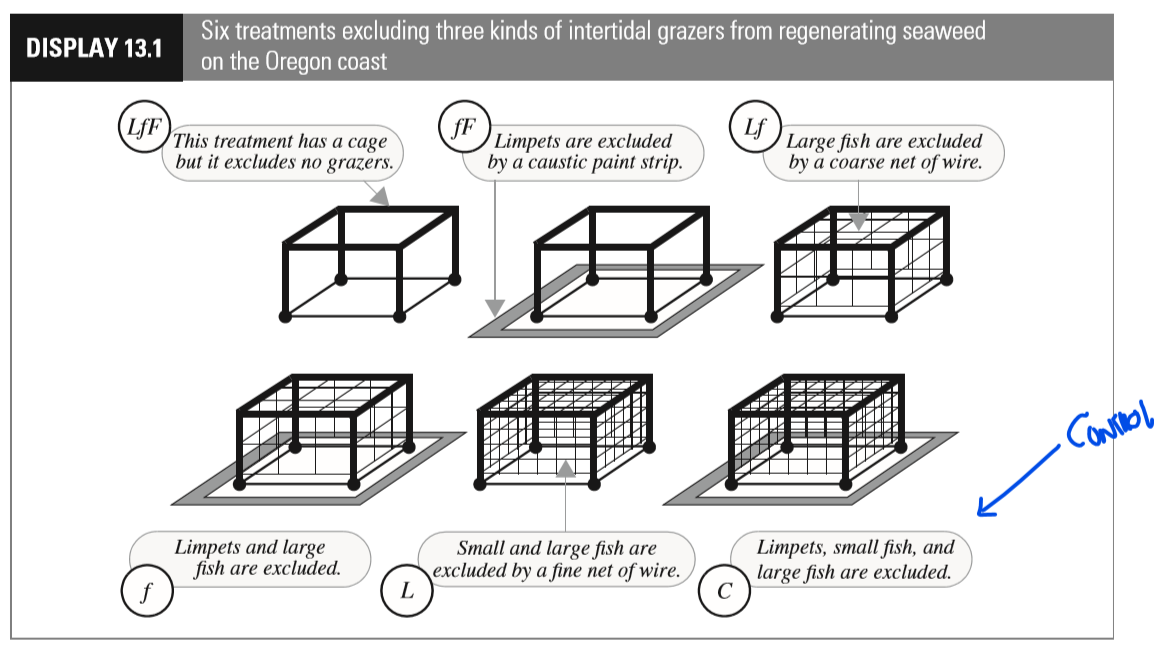



### Imports

In [70]:
import pandas as pd
import numpy as np

# import plotting libraries
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

# Statistical Packages
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("./data/case1301.csv")
df.head()

,Cover,Block,Treat
0,14,B1,CONTROL
1,23,B1,CONTROL
2,22,B2,CONTROL
3,35,B2,CONTROL
4,67,B3,CONTROL


#### Factors and Levels

There are 2 differnet factor involved in this experiment with multiple levels:

In [10]:
print("# of Unique Blocks (tidal zones): ", len(df.Block.unique()), df.Block.unique())
print("# of Unique Treatment: ", len(df.Treat.unique()), df.Treat.unique())

# of Unique Blocks (tidal zones):  8 ['B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8']
# of Unique Treatment:  6 ['CONTROL' 'L' 'f' 'Lf' 'fF' 'LfF']


### Reserach Questions
> 1. Which grazer consumes the most seaweed?
2. Do the different grazers impact each other?
3. Are grazing effects similar in all habitats?


## Exploratory Data Analysis (EDA)
To get started we perform some high level summary statistics and visualizations

In [11]:
df.describe()

,Cover
count,96.000000
mean,28.625000
std,23.631491
min,1.000000
25%,9.000000
50%,22.500000
75%,42.250000
max,95.000000


#### Additivity Check
Graph the  data to preview/visualize the factoral data and check for __nonadditivity__. We are using `statsmodels interaction_plot`. We can check for __nonadditivity__

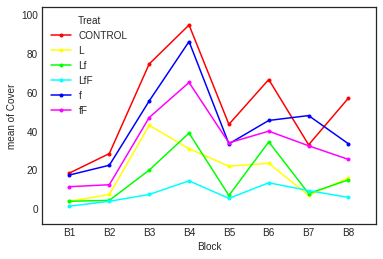

In [40]:
fig = interaction_plot(x = df.Block, trace = df.Treat, response= df.Cover)

The figure shows evidence of nonaddivity. 

#### Residual Plot

We will plot the residuals vs fitted for verification of rhte regression line. 

We expect the __values to be around `y=0`__ and we will utilize `residplot from Seaborn`. If we see a pattern, that would indicate the worse the model.

               df   sum_sq      mean_sq          F        PR(>F)
Block         7.0  19105.5  2729.357143  30.545382  1.296285e-15
Treat         5.0  23045.5  4609.100000  51.582374  3.705381e-18
Block:Treat  35.0   6612.5   188.928571   2.114379  8.128342e-03
Residual     48.0   4289.0    89.354167        NaN           NaN


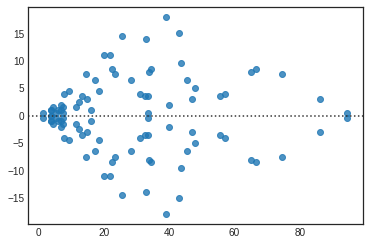

In [34]:
model = smf.ols(formula='Cover~ Block + Treat + Block:Treat', data = df).fit()
print(sm.stats.anova_lm(model))
#print(model.summary())
sns.residplot(x = model.fittedvalues, y = model.resid);
#sm.qqplot(model.resid, line='r');

#### Interpretation of Residual Plot
We can see from the __saturated model__, with a __distinct funnel shape or non-constant spread__ indicating a needed transformation. In other words we can see a __large spread in the middle of the values and little veriation at both ends of the fitted values__.

As described in the text we will have to perfomr initial transofmraiton, specifically a _logit transformation_.

![](https://i2.wp.com/taf-website-backup.s3.amazonaws.com/logit.png?resize=257%2C43)

Basically we are going to take the percent `Cover` divided by 100% minus percent `Cover` and then take the log of it. 

In [47]:
df['cover_log'] = np.log((df.Cover/(100-df.Cover)))
df.head()

,Cover,Block,Treat,cover_log
0,14,B1,CONTROL,-1.815290
1,23,B1,CONTROL,-1.208311
2,22,B2,CONTROL,-1.265666
3,35,B2,CONTROL,-0.619039
4,67,B3,CONTROL,0.708185


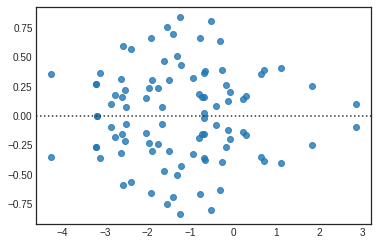

In [43]:
model = smf.ols(formula='cover_log~ Block + Treat + Block:Treat', data = df).fit()
sns.residplot(x = model.fittedvalues, y = model.resid);

Much better. 

# Models



## ANOVA non-additive

In [51]:
model = smf.ols(formula='cover_log~ Block + Treat + Block:Treat', data = df).fit()
print(sm.stats.anova_lm(model))

               df     sum_sq    mean_sq          F        PR(>F)
Block         7.0  76.238613  10.891230  35.963371  5.390313e-17
Treat         5.0  96.993222  19.398644  64.055265  4.510728e-20
Block:Treat  35.0  15.230411   0.435155   1.436902  1.209129e-01
Residual     48.0  14.536431   0.302842        NaN           NaN


### Interpretation
The table above the first three _Sources of Variation_ provides us an overview of the ___BETWEE GROUP VARIATION___ that shows us the Variation of the _average log recovery ratios_ between the `Blocks`, varation between the `Treatments` and variation between `Blocks` and `Treatments`. 

#### Conclusion
The first things we _always_ should look at is the __interactions__ or `Block:Treat` row. The F statistic and P-value is __comparing the additive model from the saturated model__. When assess the `p-value = 0.1209`, therefore, we __Fail to reject__ that there is __no evidence for no interactions__

#### Model Defintions (Full Model and Saturated Model)
So from the _Sources of Variaton_ the following are how each of the variations are being assesses
* __Fulll Model__ $\mu$`{cover_log | Block, Treat} ~ Block + Treat + Block*Treat`

__SATURATED MODELS__
* `Block` model is `cover_log ~ Treat + Blocks*Treat` compared to the __full model__
* `Treat` model is `cover_log ~ Blocks + Blocks*Treat`
* `Block:Treat` (interaction) model is `cover_log ~ Blocks + Treat`

For example, the `Treatment` variation is comparing the __Full Model__ that contains `Blocks` and `Treatments` and `Interactions` to the __Saturated Model__ that contains `Blocks` and `NO TREATMENTS` and `Interactions: Block*Treat`. If we were to interpre the `Treatment` variation `p-value = < 0.0001` we would say __there is convincing evidence for treatment sin the model after accouning for blocks for teament interactions__ .. however... in our conclusion,, we already concluded that ther is no evidence for no interactions. 



## ANOVA Additive model
Since above we concluded that there was __no interactions__ we will utilize the additive model without the interaction.

            df     sum_sq    mean_sq          F        PR(>F)
Block      7.0  76.238613  10.891230  30.368426  2.133837e-20
Treat      5.0  96.993222  19.398644  54.089967  1.094513e-24
Residual  83.0  29.766842   0.358637        NaN           NaN


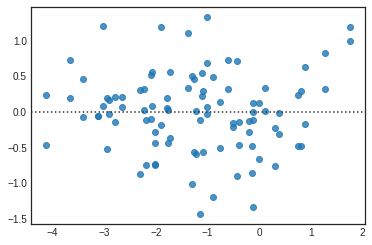

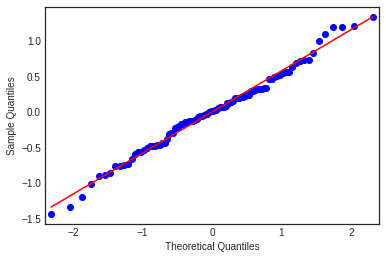

In [61]:
model = smf.ols(formula='cover_log~ Block + Treat', data = df).fit()
print(sm.stats.anova_lm(model))
sns.residplot(x = model.fittedvalues, y = model.resid);
sm.qqplot(model.resid, line='r');

#### Model Defintions (Full Model and Saturated Model)
So from the _Sources of Variaton_ the following are how each of the variations are being assesses
* __Fulll Model__ $\mu$`{cover_log | Block, Treat} ~ Block + Treat`

__SATURATED MODELS__ - basically with the additive model the saturated models do not include any interaction models. 
* `Block` model is `cover_log ~ Treat`
* `Treat` model is `cover_log ~ Blocks`

### Conclusion
Now we can interpret the resuls easier than we did in the _nonadditive model_ because we now do not have any interactions. Essentailly we can conclude: That there is __significant evidence that there is statistical difference between  `Block` and  there is significant evidence that there is statistical difference between `Treat`.__ 

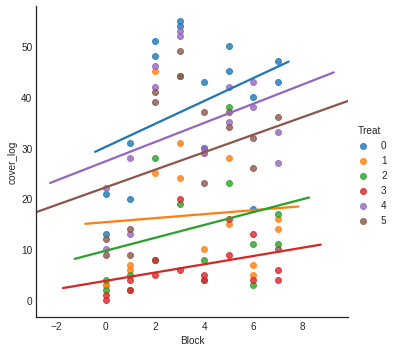

In [76]:
sns.lmplot(x ='Block', y = 'cover_log', data = data, hue = 'Treat', ci = None)

In [84]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'Block'. 
df['Blocks_code']= label_encoder.fit_transform(df['Block']) 
  
df['Blocks_code'].unique() 

array([0, 1, 2, 3, 4, 5, 6, 7])

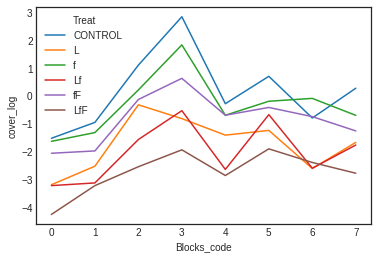

In [86]:
sns.lineplot(x ='Blocks_code', y = 'cover_log', data = df, hue = 'Treat',  ci = None)

We see mostly __parallel lines__

# Linear Combination - Estimate Effects of Blocks 

WE will use multiple linear regaression to tell us about specific animals. 

In [90]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [91]:
df_melt = pd.melt(df.reset_index(), id_vars = ['cover_log'], value_vars=['Block', 'Treat'])
df_melt.head()

,cover_log,variable,value
0,-1.815290,Block,B1
1,-1.208311,Block,B1
2,-1.265666,Block,B2
3,-0.619039,Block,B2
4,0.708185,Block,B3


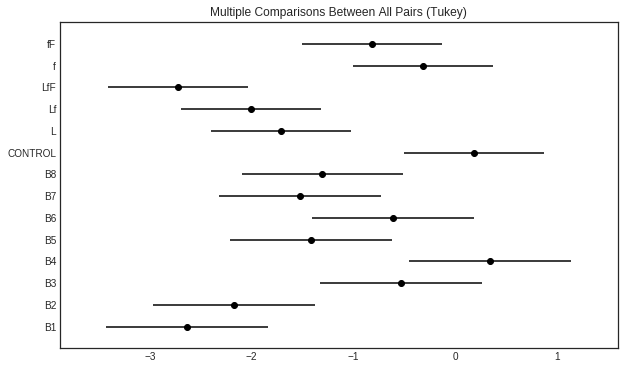

In [99]:
tukey = pairwise_tukeyhsd(endog=df_melt['cover_log'],     # Data
                          groups=df_melt['value'],   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=6.7,ymin=-0.5,ymax=4.5, color="red")

#tukey.summary() 